### **Tucson Crime Analysis**
**Author: Muhammad Asifur Rahman and Apurbo Barua
netid: apurbobarua and asifrahman
# Hypothesis: "Arrests are more frequent during late-night hours compared to daytime and evening hours, and the severity of crimes varies significantly by time of day."

 Project Overview
 The project analyzes and models crime in Tucson using data from the City of Tucson Data Hub and other sources to explore correlations, predict crime, and assess its effects on society. Ethical considerations in data usage and predictive modeling are addressed.

# Data Loading and Preprocessing


***All Imports***

In [ ]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:

# Load the datasets
arrests_df = pd.read_csv(io.StringIO(requests.get("https://drive.google.com/uc?id=1drgn_da5Fr32jSJcH_AMJuuCKCO2wAhH&export=download").text),low_memory=True,encoding=None)

income_df = pd.read_csv(io.StringIO(requests.get("https://drive.google.com/uc?id=14Oxxx26TvGlI2qhbbK18jb974TJd5duB&export=download").text),low_memory=True,encoding=None)

# Display the first few rows of each dataset
print(arrests_df.head())
print(income_df.head())

<ipython-input-101-e150e18aa724>:2: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



  IncidentNumber    ArrestID Agency              ArrestDate ArrestTime  \
0       20030810  2021024996    TPD  2021/11/25 00:00:00+00   04:00:00   
1      503150914  2021012507    TPD  2021/06/14 00:00:00+00   15:16:00   
2      102110376  2021022384    TPD  2021/10/18 00:00:00+00   21:40:00   
3      604290803  2020012742    TPD  2020/05/08 00:00:00+00   16:50:00   
4      404138015  2021009263    TPD  2021/05/03 00:00:00+00   16:06:00   

   TimeComapre        DatetimeArrested      ArrestType   JuvenileDisposition  \
0            4  2021/11/25 04:00:00+00  On-View Arrest  Unknown/Not Recorded   
1           15  2021/06/14 15:16:00+00  On-View Arrest  Unknown/Not Recorded   
2           21  2021/10/18 21:40:00+00  On-View Arrest  Unknown/Not Recorded   
3           16  2020/05/08 16:50:00+00  On-View Arrest  Unknown/Not Recorded   
4           16  2021/05/03 16:06:00+00  On-View Arrest  Unknown/Not Recorded   

  ArrestCharge  ...     Severity   Age  AgeGroup ArresteeSex  \
0    13-25



# MORE DATA PREPROCESSING

In [ ]:
# Convert DatetimeArrested to datetime format
arrests_df['DatetimeArrested'] = pd.to_datetime(arrests_df['DatetimeArrested'], errors='coerce')

# Extract hour of the day
arrests_df['Hour'] = arrests_df['DatetimeArrested'].dt.hour

# Categorize into time periods
def categorize_time(hour):
    if 6 <= hour < 18:
        return 'Daytime'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Late Night'

arrests_df['TimePeriod'] = arrests_df['Hour'].apply(categorize_time)

# Check the transformation
print(arrests_df[['DatetimeArrested', 'Hour', 'TimePeriod']].head())

           DatetimeArrested  Hour  TimePeriod
0 2021-11-25 04:00:00+00:00     4  Late Night
1 2021-06-14 15:16:00+00:00    15     Daytime
2 2021-10-18 21:40:00+00:00    21     Evening
3 2020-05-08 16:50:00+00:00    16     Daytime
4 2021-05-03 16:06:00+00:00    16     Daytime


In [ ]:
# Define the income threshold using the Wealth Index column
income_threshold = income_df['WLTHINDXCY'].median()  # Use the median as a threshold

# Categorize neighborhoods
income_df['IncomeCategory'] = income_df['WLTHINDXCY'].apply(
    lambda x: 'Low Income' if x <= income_threshold else 'High Income'
)

# Rename 'NAME' to 'Neighborhood' for merging
income_df.rename(columns={'NAME': 'Neighborhood'}, inplace=True)

# Check the transformation
print(income_df[['Neighborhood', 'WLTHINDXCY', 'IncomeCategory']].head())

       Neighborhood  WLTHINDXCY IncomeCategory
0        A Mountain          32     Low Income
1          Adelanto          28     Low Income
2  Alvernon Heights          26     Low Income
3             Amphi          20     Low Income
4       Armory Park          48    High Income


In [ ]:
print(arrests_df.columns)
print(income_df.columns)
print(arrests_df.sample(5))  # Check random samples for geographic data


Index(['IncidentNumber', 'ArrestID', 'Agency', 'ArrestDate', 'ArrestTime',
       'TimeComapre', 'DatetimeArrested', 'ArrestType', 'JuvenileDisposition',
       'ArrestCharge', 'ArrestChargeDescription', 'Severity', 'Age',
       'AgeGroup', 'ArresteeSex', 'ArresteeRace', 'ArresteeEthnicity',
       'ArrestYear', 'YeartoDate', 'ArrestChargeandDescription', 'ESRI_OID',
       'Hour', 'TimePeriod'],
      dtype='object')
Index(['OBJECTID', 'Neighborhood', 'WARD', 'DATASOURCE', 'ID', 'sourceCountry',
       'ENRICH_FID', 'aggregationMethod', 'populationToPolygonSizeRating',
       'apportionmentConfidence',
       ...
       'ID_1', 'sourceCountry_1', 'ENRICH_FID_1', 'aggregationMethod_1',
       'populationToPolygonSizeRating_1', 'apportionmentConfidence_1',
       'HasData_1', 'TOTHH_CY', 'WLTHINDXCY', 'IncomeCategory'],
      dtype='object', length=169)
       IncidentNumber     ArrestID Agency              ArrestDate ArrestTime  \
167754     2404020087  AR240005548    TPD  2024/04/02 

In [ ]:
# Group by TimePeriod
arrest_summary = arrests_df.groupby(['TimePeriod']).size().reset_index(name='ArrestCount')

# Group by TimePeriod and Severity
severity_summary = arrests_df.groupby(['TimePeriod', 'Severity']).size().reset_index(name='ArrestCount')

# Preview the summaries
print(arrest_summary)
print(severity_summary)

   TimePeriod  ArrestCount
0     Daytime        83167
1     Evening        52697
2  Late Night        37542
    TimePeriod              Severity  ArrestCount
0      Daytime                 Civil          926
1      Daytime         Civil Traffic          306
2      Daytime     Civil/Misdemeanor            2
3      Daytime              Criminal         3625
4      Daytime      Criminal Traffic           40
5      Daytime            DEFLECTION            4
6      Daytime                Felony        20050
7      Daytime    Felony/Misdemeanor         4290
8      Daytime           Misdemeanor        51814
9      Daytime             Municipal            2
10     Daytime        Not Applicable           62
11     Daytime         Petty Offense           27
12     Daytime        Status Offense          214
13     Daytime  Unknown/Not Recorded         1779
14     Daytime               Warning           15
15     Daytime                                 11
16     Evening                 Civil      

**USING DATA VISUALIZATION FOR UNDERSTANDING THE DATA

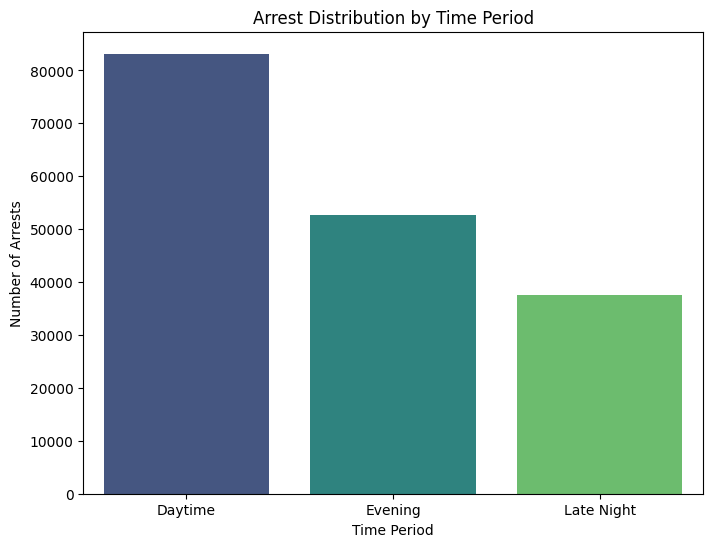

In [ ]:

# Bar chart for overall arrests by time period
plt.figure(figsize=(8, 6))
sns.barplot(data=arrest_summary, x='TimePeriod', y='ArrestCount', hue='TimePeriod', dodge=False, palette='viridis')
plt.title('Arrest Distribution by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Number of Arrests')
plt.show()


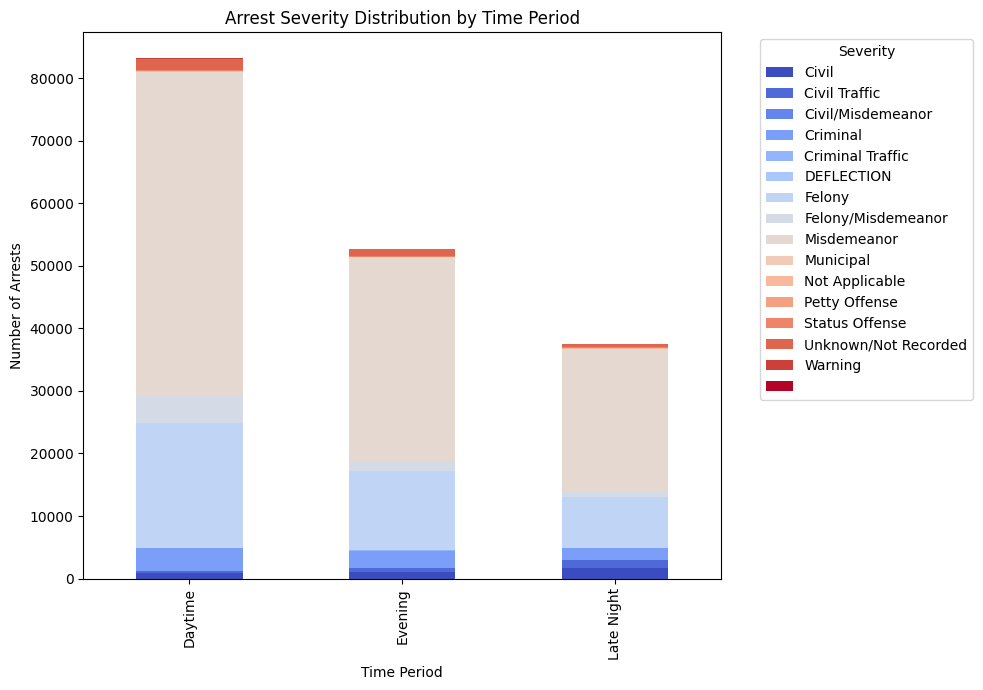

In [ ]:
# Pivot severity_summary for stacked bar chart
severity_pivot = severity_summary.pivot(index='TimePeriod', columns='Severity', values='ArrestCount').fillna(0)

# Plot stacked bar chart
severity_pivot.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='coolwarm')
plt.title('Arrest Severity Distribution by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Number of Arrests')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:


# Create a contingency table for time period and severity
contingency_table = severity_summary.pivot(index='TimePeriod', columns='Severity', values='ArrestCount').fillna(0)

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")


Chi-square statistic: 4069.7554662363073, p-value: 0.0


    TimePeriod               AgeGroup  ArrestCount
0      Daytime                  15-18         2753
1      Daytime                  19-25        14628
2      Daytime                  26-36        33362
3      Daytime                  37-46        17743
4      Daytime                  47-56         8048
5      Daytime                  57-64         3370
6      Daytime                    65+         1400
7      Daytime                   8-14          959
8      Daytime                Below 8            3
9      Daytime  Unknown/ Not Recorded          901
10     Evening                  15-18         2155
11     Evening                  19-25         9877
12     Evening                  26-36        20132
13     Evening                  37-46        11305
14     Evening                  47-56         5149
15     Evening                  57-64         2119
16     Evening                    65+          756
17     Evening                   8-14          630
18     Evening  Unknown/ Not Re

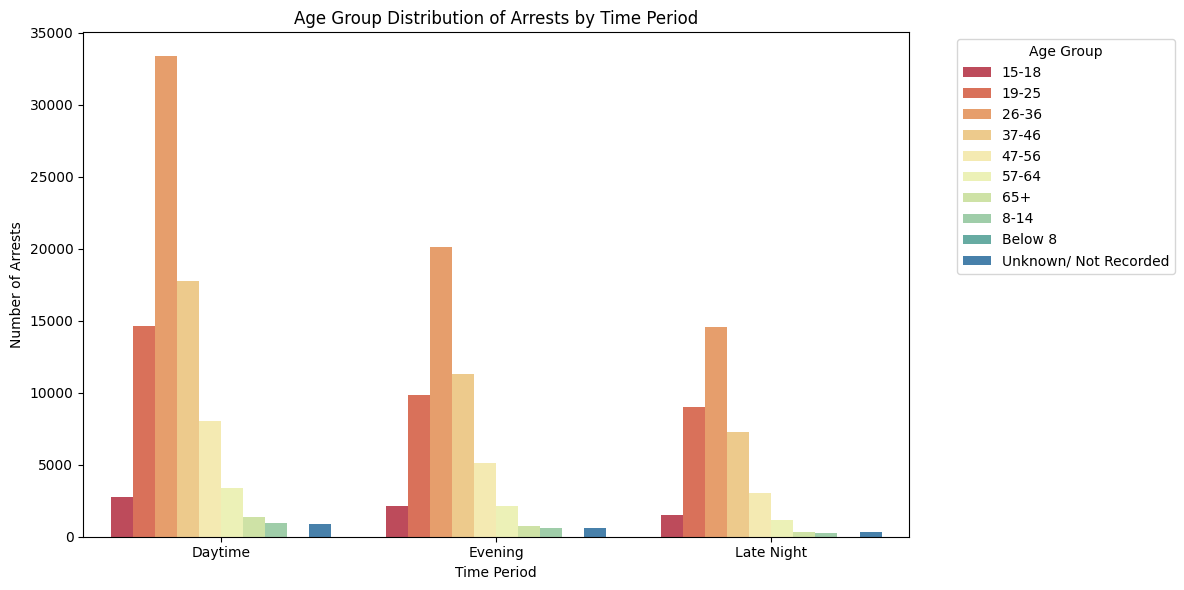

In [ ]:
# Group by TimePeriod and AgeGroup
age_summary = arrests_df.groupby(['TimePeriod', 'AgeGroup']).size().reset_index(name='ArrestCount')

# View the age distribution
print(age_summary)

# Visualize the age distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=age_summary, x='TimePeriod', y='ArrestCount', hue='AgeGroup', palette='Spectral')
plt.title('Age Group Distribution of Arrests by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Number of Arrests')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


    TimePeriod                               ArresteeRace  ArrestCount
0      Daytime           American Indian or Alaska Native         3382
1      Daytime                                      Asian          390
2      Daytime                  Black or African American        12297
3      Daytime                         Hispanic or Latino        34431
4      Daytime                             Middle Eastern          160
5      Daytime  Native Hawaiian or Other Pacific Islander           63
6      Daytime                       Unknown/Not Recorded         2273
7      Daytime                                      White        30171
8      Evening           American Indian or Alaska Native         2097
9      Evening                                      Asian          271
10     Evening                  Black or African American         7537
11     Evening                         Hispanic or Latino        22522
12     Evening                             Middle Eastern          114
13    

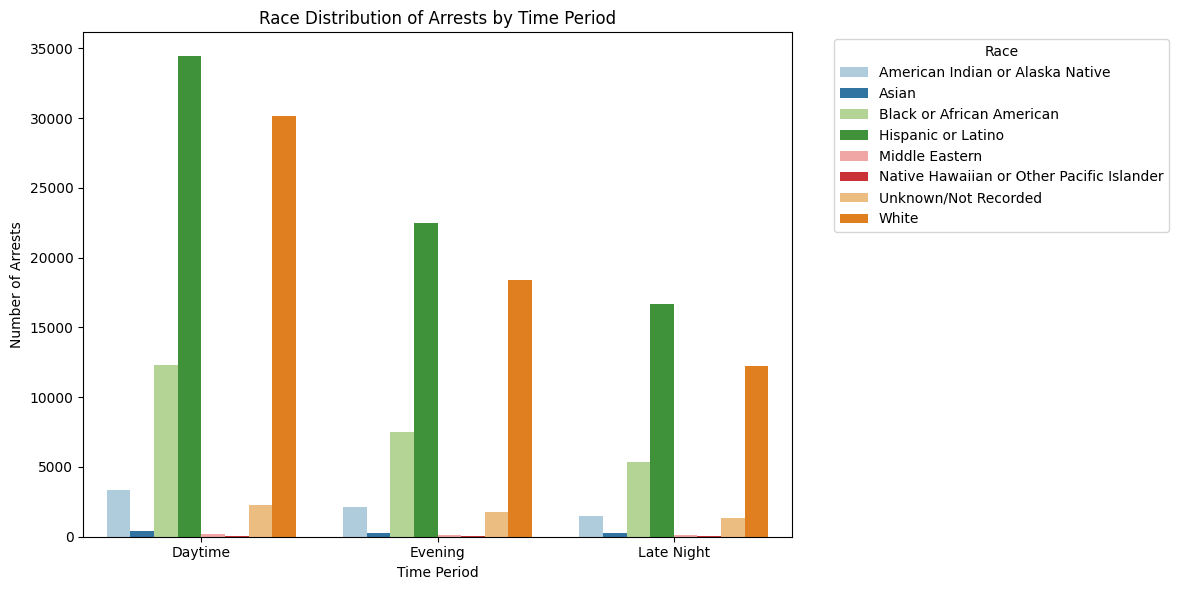

In [ ]:
# Group by TimePeriod and ArresteeRace
race_summary = arrests_df.groupby(['TimePeriod', 'ArresteeRace']).size().reset_index(name='ArrestCount')

# View the race distribution
print(race_summary)

# Visualize the race distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=race_summary, x='TimePeriod', y='ArrestCount', hue='ArresteeRace', palette='Paired')
plt.title('Race Distribution of Arrests by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Number of Arrests')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


    TimePeriod                         ArrestChargeDescription  ArrestCount
0      Daytime                          3RD DEGREE TRESPASSING         3822
1      Daytime                                 CRIMINAL DAMAGE         2264
2      Daytime                       CRIMINAL TRESPASS 3RD DEG         3015
3      Daytime                           DISORDERLY CONDUCT/DV         2964
4      Daytime  DRIVING WHILE IMPAIRED TO THE SLIGHTEST DEGREE          742
5      Daytime                    DRUG PARAPHERNALIA VIOLATION         4967
6      Daytime     DRUG PARAPHERNALIA-POSSESS/SELL/MANUFACTURE         3191
7      Daytime                       FAILURE TO APPEAR 1ST DEG         1967
8      Daytime                       FAILURE TO APPEAR 2ND DEG         5360
9      Daytime                FAILURE TO APPEAR 2ND DEG (CRIM)         3241
10     Evening                          3RD DEGREE TRESPASSING         1766
11     Evening                                 CRIMINAL DAMAGE         1672
12     Eveni

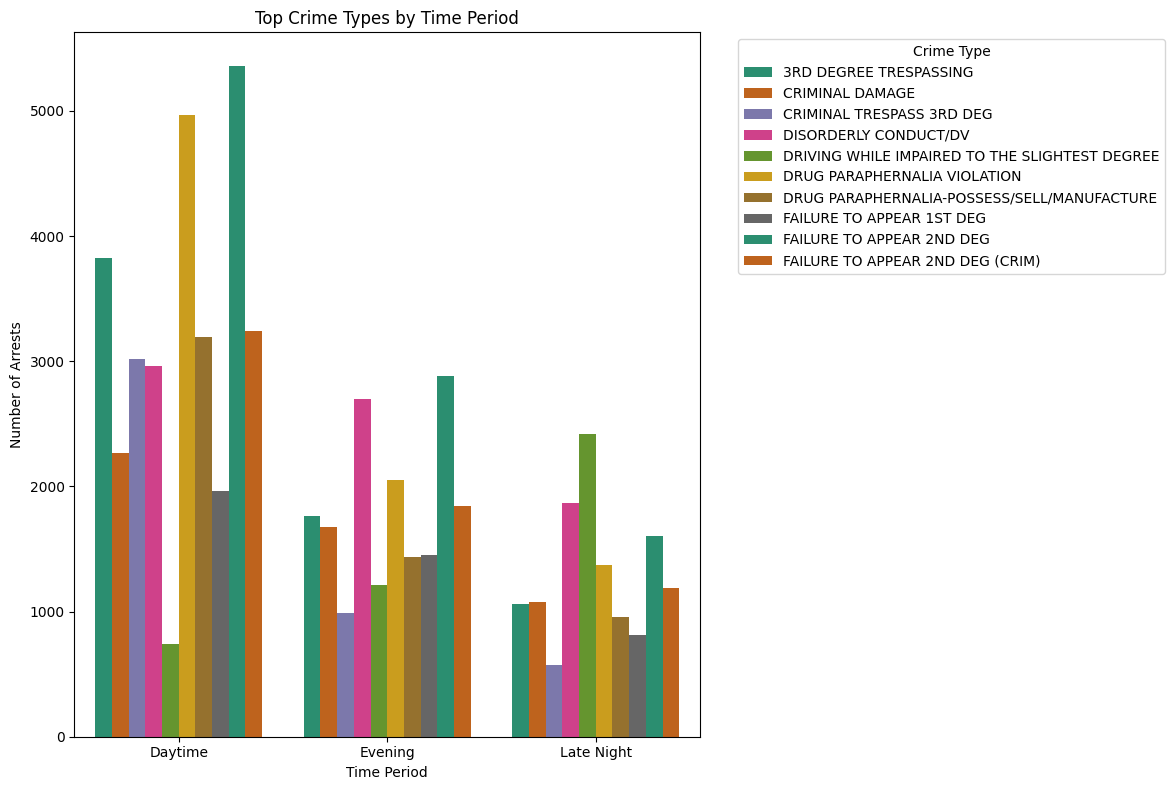

In [ ]:
# Extract top crime types for simplicity
top_crimes = arrests_df['ArrestChargeDescription'].value_counts().head(10).index
crime_filtered = arrests_df[arrests_df['ArrestChargeDescription'].isin(top_crimes)]

# Group by TimePeriod and ArrestChargeDescription
crime_summary = crime_filtered.groupby(['TimePeriod', 'ArrestChargeDescription']).size().reset_index(name='ArrestCount')

# View the crime distribution
print(crime_summary)

# Visualize the crime type distribution
plt.figure(figsize=(12, 8))
sns.barplot(data=crime_summary, x='TimePeriod', y='ArrestCount', hue='ArrestChargeDescription', palette='Dark2')
plt.title('Top Crime Types by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Number of Arrests')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


    ArrestYear  TimePeriod  ArrestCount  PercentChange
0         2020     Daytime        21277            NaN
1         2020     Evening        13366            NaN
2         2020  Late Night         9197            NaN
3         2021     Daytime        19300      -9.291723
4         2021     Evening        13156      -1.571151
5         2021  Late Night         9173      -0.260955
6         2022     Daytime        16938     -12.238342
7         2022     Evening        11144     -15.293402
8         2022  Late Night         7912     -13.746866
9         2023     Daytime        18294       8.005668
10        2023     Evening        10640      -4.522613
11        2023  Late Night         8305       4.967139
12        2024     Daytime         7358     -59.779163
13        2024     Evening         4391     -58.731203
14        2024  Late Night         2955     -64.419025


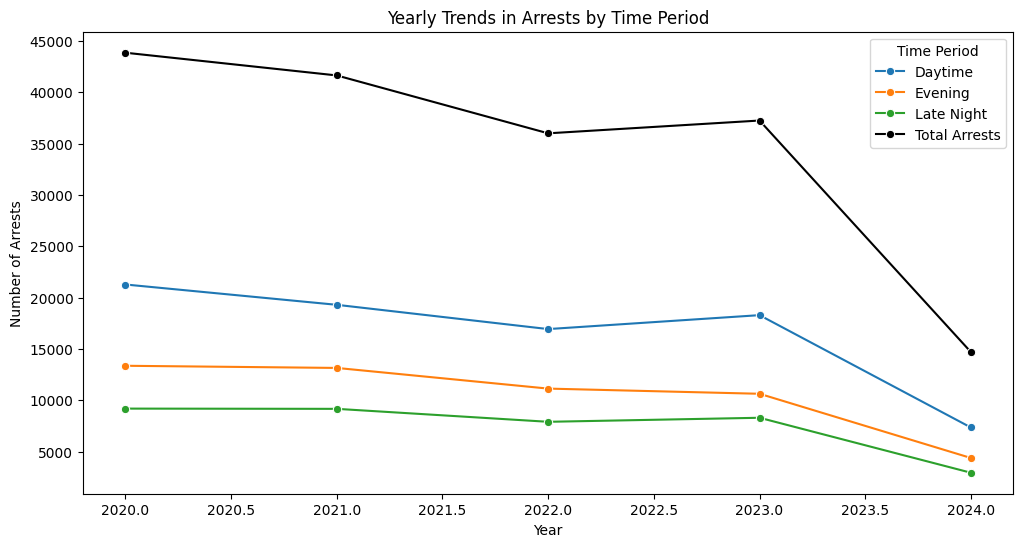

In [ ]:
# Calculate yearly arrest summary
yearly_summary = arrests_df.groupby(['ArrestYear', 'TimePeriod']).size().reset_index(name='ArrestCount')

# Calculate percentage change
yearly_summary['PercentChange'] = yearly_summary.groupby('TimePeriod')['ArrestCount'].pct_change() * 100

# View the results
print(yearly_summary)

# Total yearly arrests
total_yearly = arrests_df.groupby('ArrestYear').size().reset_index(name='TotalArrests')

# Plot total alongside time periods
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_summary, x='ArrestYear', y='ArrestCount', hue='TimePeriod', marker='o')
sns.lineplot(data=total_yearly, x='ArrestYear', y='TotalArrests', color='black', label='Total Arrests', marker='o')
plt.title('Yearly Trends in Arrests by Time Period')
plt.xlabel('Year')
plt.ylabel('Number of Arrests')
plt.legend(title='Time Period')
plt.show()

**After seeing the visual data, it was clear that our hypothesis that " Arrests are more frequent during late-night hours compared to daytime and evening hours, and the severity of crimes varies significantly by time of day" was clearly wrong as it is evident from all the graph that arrested crime happen in daytime more compared to nightime and evening time. So adjusted Hypothesis is**

#**Arrests are more frequent during datime hours compared to late night and evening hours, and the severity of crimes varies significantly by time of day**





#**MODEL TRAINING: Logistical Regression**

In [ ]:


# Prepare data for logistic regression
features = ['Age', 'Severity']  # Select relevant features
target = 'TimePeriod'

if 'TimeComapre' in arrests_df.columns:
    # Define time periods based on TimeComapre values
    def categorize_time_compare(hour):
        if 6 <= hour < 18:
            return 'Daytime'
        elif 18 <= hour < 24:
            return 'Evening'
        else:
            return 'Late Night'

    arrests_df['TimePeriod'] = arrests_df['TimeComapre'].apply(categorize_time_compare)
else:

    arrests_df['TimePeriod'] = pd.to_datetime(arrests_df['DatetimeArrested']).dt.hour.apply(categorize_time_compare)


print(arrests_df[['TimeComapre', 'TimePeriod']].head())
print(arrests_df['TimePeriod'].isnull().sum())


arrests_df['TimePeriod'] = arrests_df['TimePeriod'].map({'Daytime': 0, 'Evening': 1, 'Late Night': 2})
arrests_df['Severity'] = arrests_df['Severity'].astype('category').cat.codes

X = arrests_df[features]
y = arrests_df[target]

# Handle missing values in X (features)
X = X.fillna(X.median())
y = y.dropna()

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))

   TimeComapre  TimePeriod
0            4  Late Night
1           15     Daytime
2           21     Evening
3           16     Daytime
4           16     Daytime
0
              precision    recall  f1-score   support

           0       0.48      0.99      0.65     24885
           1       0.00      0.00      0.00     15843
           2       0.53      0.05      0.09     11294

    accuracy                           0.48     52022
   macro avg       0.34      0.35      0.25     52022
weighted avg       0.35      0.48      0.33     52022

Accuracy: 0.48477567183114834


# **Random Forest Test**

In [ ]:


# Prepare data for Random Forest
features = ['Age', 'Severity']  # Select relevant features
target = 'TimePeriod'

# Ensure 'TimePeriod' is created correctly:
if 'TimeComapre' in arrests_df.columns:
    def categorize_time_compare(hour):
        if 6 <= hour < 18:
            return 'Daytime'
        elif 18 <= hour < 24:
            return 'Evening'
        else:
            return 'Late Night'

    arrests_df['TimePeriod'] = arrests_df['TimeComapre'].apply(categorize_time_compare)
else:
    arrests_df['TimePeriod'] = pd.to_datetime(arrests_df['DatetimeArrested']).dt.hour.apply(categorize_time_compare)

# Map 'TimePeriod' to numeric values
arrests_df['TimePeriod'] = arrests_df['TimePeriod'].map({'Daytime': 0, 'Evening': 1, 'Late Night': 2})

# Convert categorical 'Severity' to numeric
arrests_df['Severity'] = arrests_df['Severity'].astype('category').cat.codes

# Select features and target
X = arrests_df[features]
y = arrests_df[target]

# Handle missing values in features
X = X.fillna(X.median())

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.52      0.44      0.48     24885
           1       0.33      0.32      0.32     15843
           2       0.29      0.40      0.33     11294

    accuracy                           0.39     52022
   macro avg       0.38      0.39      0.38     52022
weighted avg       0.41      0.39      0.40     52022

Accuracy: 0.393372034908308


**EVALUATION OF MODEL**

In [ ]:



log_accuracy = accuracy_score(y_test, log_y_pred)
log_class_report = classification_report(y_test, log_y_pred, output_dict=True, zero_division=0)  # Suppress warnings
log_f1_macro = log_class_report["macro avg"]["f1-score"]


rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_class_report = classification_report(y_test, rf_y_pred, output_dict=True, zero_division=0)  # Suppress warnings
rf_f1_macro = rf_class_report["macro avg"]["f1-score"]


print("Model Comparison:")
print(f"Logistic Regression - Accuracy: {log_accuracy:.4f}, Macro F1-Score: {log_f1_macro:.4f}")
print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, Macro F1-Score: {rf_f1_macro:.4f}")


Model Comparison:
Logistic Regression - Accuracy: 0.4784, Macro F1-Score: 0.2157
Random Forest - Accuracy: 0.3656, Macro F1-Score: 0.3509
